In [1]:
!pip3 install pyro-ppl 

In [2]:
import os
import torch
import pyro
import logging
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.style.use('default')
logging.basicConfig(format='%(message)s', level=logging.INFO)

## Generate artificial data set


In [4]:
import numpy as np

N = 500  # number of data points
K = 2  # number of components

pi = np.array([0.4, 0.6])
mus = [1, -1]
stds = [0.1,0.3]
x_train = np.zeros(N, dtype=np.float32)
for n in range(N):
  k = np.argmax(np.random.multinomial(1, pi))
  x_train[n] = np.random.normal(mus[k], stds[k])

x_train = torch.tensor(x_train, dtype=torch.float)

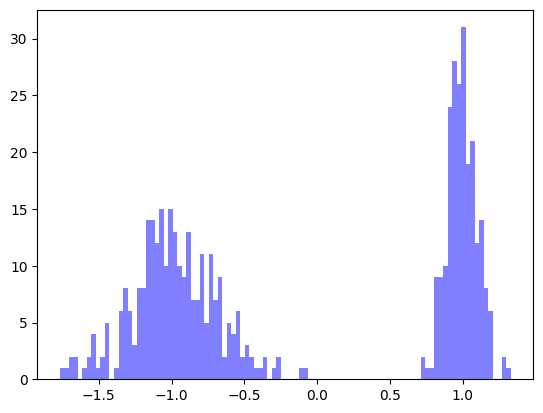

In [5]:
num_bins = 100
n, bins, patches = plt.hist(x_train, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [6]:
import pyro.distributions as dist

def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        scale = pyro.sample('scale', dist.LogNormal(0., 2.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        return pyro.sample('obs', dist.Normal(locs[assignment], scale[assignment]), obs=data)

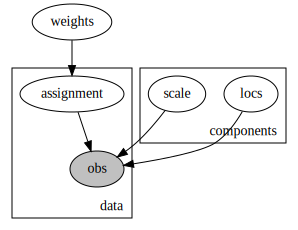

In [7]:
pyro.render_model(model, model_args=(x_train,))

In [8]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=3000)
mcmc.run(x_train)
posterior_samples = mcmc.get_samples()


Sample: 100%|██████████| 3500/3500 [03:20, 17.50it/s, step size=6.97e-01, acc. prob=0.913]


In [9]:
print(posterior_samples['locs'].mean(dim=0))
print(posterior_samples['scale'].mean(dim=0))

tensor([-0.9823,  0.9941])
tensor([0.2962, 0.1030])
